Import all necessary libraries

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import os
import glob
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

from object_detection.utils import visualization_utils as viz_utils

2024-01-16 12:53:58.317644: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-16 12:53:59.930174: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Here I want to use different networks and compare the results.
All these networks were trained on different dataSets, so I need to prepare labels for each of them.

In [2]:
# ImageNetLabels

# labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
# imagenet_labels = np.array(open(labels_path).read().splitlines())
# print(imagenet_labels)

In [3]:
# COCOLabels

# List of the strings that is used to add correct label for each box
coco_labels = {}
PATH_TO_LABELS = 'coco_labels.txt'
labels = np.array(open(PATH_TO_LABELS).read().splitlines())
for row in labels:
    label = row.split(': ')
    coco_labels[int(label[0])] = {'name':label[1]}
print(coco_labels)

{1: {'name': 'person'}, 2: {'name': 'bicycle'}, 3: {'name': 'car'}, 4: {'name': 'motorcycle'}, 5: {'name': 'airplane'}, 6: {'name': 'bus'}, 7: {'name': 'train'}, 8: {'name': 'truck'}, 9: {'name': 'boat'}, 10: {'name': 'traffic light'}, 11: {'name': 'fire hydrant'}, 13: {'name': 'stop sign'}, 14: {'name': 'parking meter'}, 15: {'name': 'bench'}, 16: {'name': 'bird'}, 17: {'name': 'cat'}, 18: {'name': 'dog'}, 19: {'name': 'horse'}, 20: {'name': 'sheep'}, 21: {'name': 'cow'}, 22: {'name': 'elephant'}, 23: {'name': 'bear'}, 24: {'name': 'zebra'}, 25: {'name': 'giraffe'}, 27: {'name': 'backpack'}, 28: {'name': 'umbrella'}, 31: {'name': 'handbag'}, 32: {'name': 'tie'}, 33: {'name': 'suitcase'}, 34: {'name': 'frisbee'}, 35: {'name': 'skis'}, 36: {'name': 'snowboard'}, 37: {'name': 'sports ball'}, 38: {'name': 'kite'}, 39: {'name': 'baseball bat'}, 40: {'name': 'baseball glove'}, 41: {'name': 'skateboard'}, 42: {'name': 'surfboard'}, 43: {'name': 'tennis racket'}, 44: {'name': 'bottle'}, 46: {

For easier access to different neural networks I created a dictionary with all necessary details of each used network.

In [4]:
nn_models = {
    'mobilenet': {
        'size': 320,
        'url': "https://www.kaggle.com/models/tensorflow/ssd-mobilenet-v2/frameworks/TensorFlow2/variations/ssd-mobilenet-v2/versions/1",
        'labels': coco_labels
    }
}

Set current neural network model and load detector from Hub.

In [5]:
CURRENT_MODEL = 'mobilenet'
SIZE = nn_models[CURRENT_MODEL]['size']
URL = nn_models[CURRENT_MODEL]['url']
LABELS = nn_models[CURRENT_MODEL]['labels']

# no need to make it a keras layer
detector = hub.load(URL)

# or with KerasLayer, result is the same
# m = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/ssd-mobilenet-v2/frameworks/TensorFlow2/variations/ssd-mobilenet-v2/versions/1",
#                    signature = 'serving_default',
#                    signature_outputs_as_dict=True)

2024-01-16 12:54:28.582310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-16 12:54:28.834706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-16 12:54:28.834857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-16 12:54:28.839657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-16 12:54:28.839859: I tensorflow/compile

Add helpers for image manipulations.

In [6]:
# helpers
def load(img_path):
    image = cv2.imread(img_path)
    return image

def show_image(image, title=''):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.show()

def image_tensor(image, width, height):    
    image = cv2.resize(image, (width, height))
    # The input images are expected to have color values in the range [0,1]
    # image = image/255.0
    image_np = np.asarray(image)
    input_tensor = np.expand_dims(image_np, 0)
    return input_tensor

def visualize(image, detections, labels):
    image_np_with_detections = image.copy().astype(int)
    label_id_offset = 0

    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'][0].numpy(),
            (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
            detections['detection_scores'][0].numpy(),
            labels,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=.5,
            agnostic_mode=False,
    )
    return image_np_with_detections

def plot_images(images, columns, figsize=(30,50)):
    n_images = len(images)
    fig = plt.figure(figsize=figsize)
    for n, image in enumerate(images):
        fig.add_subplot(int(np.ceil(n_images/float(columns))), columns, n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
    plt.show()

Load images and test detector and vilization of detection on one image.

In [7]:
# select only chunk of data
testDataPath = os.path.dirname(os.getcwd()) + "/DaimlerBenchmark/Data/TestData/"
filenamesList = glob.glob(testDataPath+'00m_2*.pgm')
print(len(filenamesList))

96


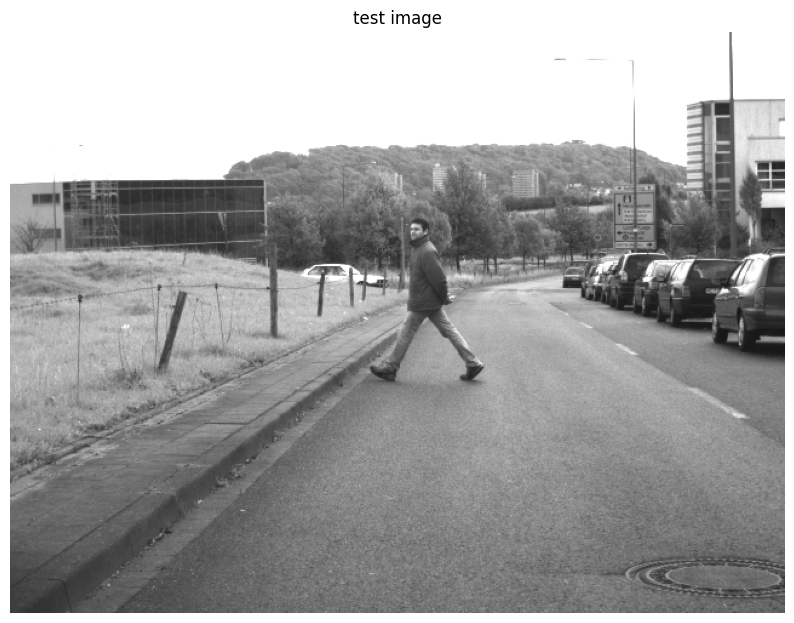

In [12]:
# load one image
%matplotlib inline
image = load(filenamesList[50])
show_image(image, 'test image')

I use Tensorflow with GPU and in wsl2 there are problems with linking to libcuda.so as Nvidia installs it without symlinks.

Fix:
```
cd /usr/lib/wsl/lib
sudo rm libcuda.so libcuda.so.1
sudo ln -s libcuda.so.1.1 libcuda.so.1
sudo ln -s libcuda.so.1 libcuda.so
sudo ldconfig

<!-- maybe also export lib path -->
export LD_LIBRARY_PATH=/usr/lib/wsl/lib:$LD_LIBRARY_PATH
```

In [13]:
# test if the detector works
tr_image = image_tensor(image,SIZE,SIZE)
print(tr_image.shape)

detector_output = detector(tr_image)

(1, 320, 320, 3)


2024-01-16 12:56:49.033953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-16 12:56:49.398869: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


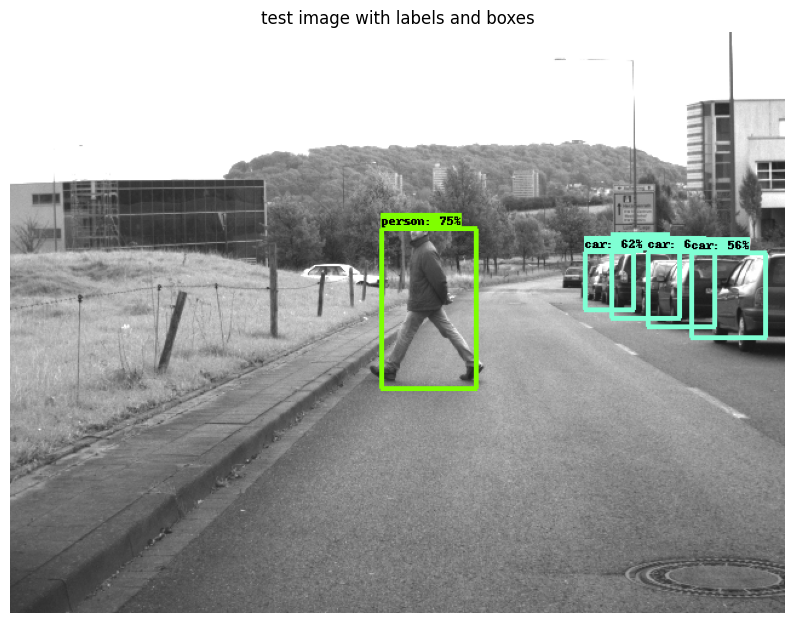

In [14]:
# test visualization with deteced boxes and labels
%matplotlib inline
vis_image = visualize(image,detector_output,LABELS)
show_image(vis_image, 'test image with labels and boxes')

Now I can make a detection pipeline.

In [15]:
# detection pipeline

def detect(fileList, cur_nn, cv_show=False):
    detectedImages = []
    SIZE = nn_models[cur_nn]['size']
    LABELS = nn_models[cur_nn]['labels']
    
    for im in fileList:
        cur_image = load(im)
        cur_tr_image = image_tensor(cur_image,SIZE,SIZE)

        cur_detector_output = detector(cur_tr_image)

        cur_vis_image = visualize(cur_image,cur_detector_output,LABELS)
        
        # show the output images
        h,w,ch = cur_vis_image.shape 
        detectedImages.append(cur_vis_image.astype("uint8"))

        # to show
        if cv_show:
            res_image = cv2.resize(cur_vis_image.astype('float32'), (w*2,h*2,))
            cv2.imshow("detected", res_image.astype("uint8"))
            cv2.waitKey(10)

    cv2.destroyAllWindows()
    return detectedImages

And detect all images I want.

In [16]:
# detect images with current neural network model
detected_images = detect(filenamesList, CURRENT_MODEL, cv_show=True)

Optional import to gif.

In [17]:
import imageio
gif_name = os.path.dirname(os.getcwd()) + "/object_detection/detected/one.gif"
imageio.mimsave(gif_name, detected_images)

And finally I can also plot some of the detected images. 

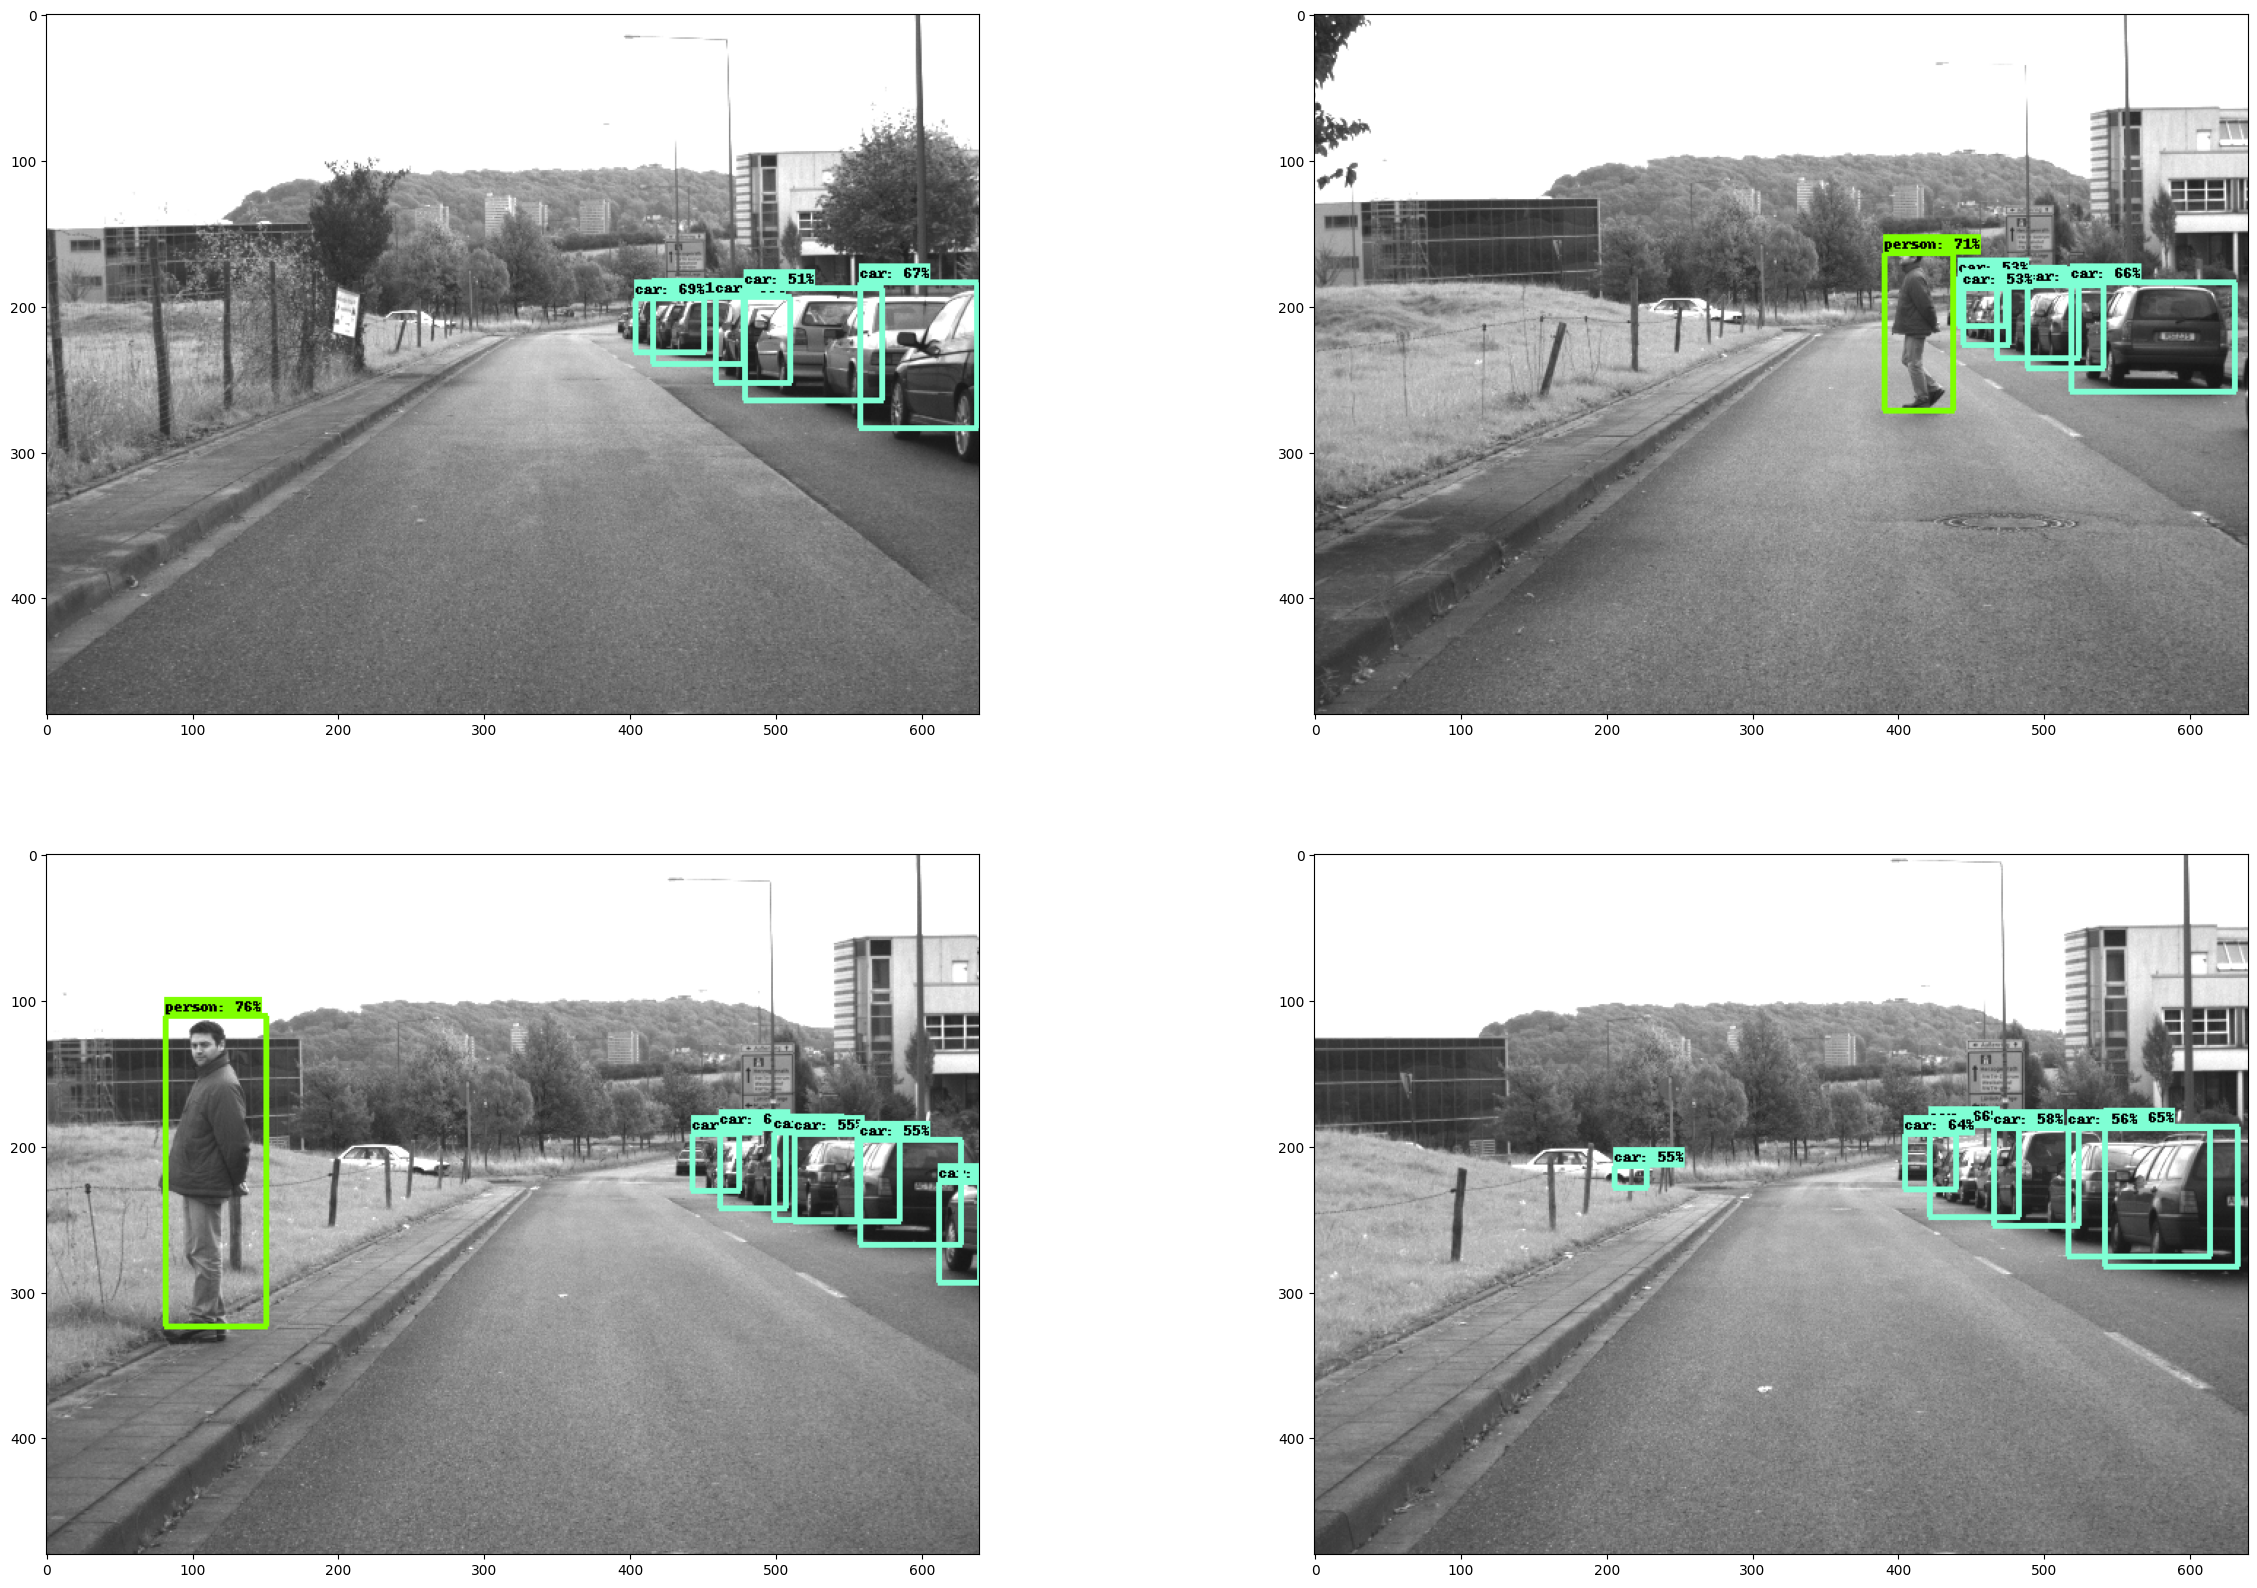

In [20]:
images_for_plot = []
images_for_plot.append(detected_images[20])
images_for_plot.append(detected_images[40])
images_for_plot.append(detected_images[60])
images_for_plot.append(detected_images[75])
plot_images(images_for_plot, 2, (30,20))